In [1]:
import pylhe
import ROOT
import math
import os
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
import time

t1 = time.time()

Welcome to JupyROOT 6.20/04


In [2]:
##### setting file path #####

sig_rootpath = "/data/Chen-Wang/checkCWCB/Events/run_01/tag_1_delphes_events.root"
sig_file = uproot.open(sig_rootpath)

bg_rootpath = "/data/Chen-Wang/llaaBGlarge/Events/run_01/tag_1_delphes_events.root"
bg_file = uproot.open(bg_rootpath)

In [3]:
##### set signal event content #####

sig_events = [sig_file["Delphes;1"]["Electron"].array(),
              sig_file["Delphes;1"]["Electron.PT"].array(),
              sig_file["Delphes;1"]["Electron.Phi"].array(),
              sig_file["Delphes;1"]["Electron.Eta"].array(),
              sig_file["Delphes;1"]["Muon"].array(),
              sig_file["Delphes;1"]["Muon.PT"].array(),
              sig_file["Delphes;1"]["Muon.Phi"].array(),
              sig_file["Delphes;1"]["Muon.Eta"].array(),
              sig_file["Delphes;1"]["Photon"].array(),
              sig_file["Delphes;1"]["Photon.PT"].array(),
              sig_file["Delphes;1"]["Photon.Phi"].array(),
              sig_file["Delphes;1"]["Photon.Eta"].array()
             ]

sig_events = np.expand_dims(sig_events, axis=-1)    ### reshape data
sig_events = sig_events.transpose((1,0,2))
sig_events = np.squeeze(sig_events,axis=(2,))

##### set background event content #####

bg_events = [bg_file["Delphes;1"]["Electron"].array(),
             bg_file["Delphes;1"]["Electron.PT"].array(),
             bg_file["Delphes;1"]["Electron.Phi"].array(),
             bg_file["Delphes;1"]["Electron.Eta"].array(),
             bg_file["Delphes;1"]["Muon"].array(),
             bg_file["Delphes;1"]["Muon.PT"].array(),
             bg_file["Delphes;1"]["Muon.Phi"].array(),
             bg_file["Delphes;1"]["Muon.Eta"].array(),
             bg_file["Delphes;1"]["Photon"].array(),
             bg_file["Delphes;1"]["Photon.PT"].array(),
             bg_file["Delphes;1"]["Photon.Phi"].array(),
             bg_file["Delphes;1"]["Photon.Eta"].array()
             ]

bg_events = np.expand_dims(bg_events, axis=-1)    ### reshape data
bg_events = bg_events.transpose((1,0,2))
bg_events = np.squeeze(bg_events,axis=(2,))

##### event features #####

features = ["Electron", "Electron.PT", "Electron.Phi", "Electron.Eta", "Muon", "Muon.PT", "Muon.Phi", "Muon.Eta", "Photon", "Photon.PT", "Photon.Phi", "Photon.Eta"]
electron_mass = 0.000511
muon_mass = 0.10566

In [4]:
################################
##### Some useful function #####
################################

##### select if =2 photon #####

def photon_selection(events):
    where1 = np.where(events[:,8]==2)    ### 8:number of photon
    return events[where1]

##### select if =2 lepton #####

def lepton_selection(events):
    where_electron = np.where(events[:,0]==2)    ### 0:number of electron
    where_muon = np.where(events[:,4]==2)    ### 4:number of muon
    return events[where_electron], events[where_muon]

##### calculate m_ll #####

def m_ll(events, m_ll):
    where1 = []
    where_select = []
    for i in range(len(events)):
        p = [0,0,0,0]    ### four momentum
        if events[i][0]==2:    ### electron case
            for j in range(2):
                pt = events[i][1][j]    ### 1:electron transverse momentum
                phi = events[i][2][j]    ### 2:electron polar angle
                eta = events[i][3][j]    ### 3:electron pseudorapidity
                p[1] = p[1] + pt*np.cos(phi)    ### px
                p[2] = p[2] + pt*np.sin(phi)    ### py
                p[3] = p[3] + pt*np.sinh(eta)    ### pz
                p[0] = p[0] + np.sqrt( electron_mass**2 + (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy
        elif events[i][4]==2:    ### muon case
            for j in range(2):
                pt = events[i][5][j]    ### 5:muon transverse momentum
                phi = events[i][6][j]    ### 6:muon polar angle
                eta = events[i][7][j]    ### 7:muon pseudorapidity
                p[1] = p[1] + pt*np.cos(phi)    ### px
                p[2] = p[2] + pt*np.sin(phi)    ### py
                p[3] = p[3] + pt*np.sinh(eta)    ### pz
                p[0] = p[0] + np.sqrt( muon_mass**2 + (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy
        mll = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        if 0<=mll<=250:
            m_ll.append(mll)
            where1.append(i)
        if 80<=mll<=100:
            where_select.append(i)
    return events[where1], events[where_select]

##### calculate m_aa and pT_aa #####

def m_aa(events, m_aa, pT_aa):
    for i in range(len(events)):
        p = [0,0,0,0]    ### four momentum
        for j in range(events[i][8]):
            pt = events[i][9][j]    ### 9:photon transverse momentum
            phi = events[i][10][j]    ### 10:photon polar angle
            eta = events[i][11][j]    ### 11:photon pseudorapidity
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
            p[3] = p[3] + pt*np.sinh(eta)    ### pz
            p[0] = p[0] + np.sqrt( (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy with photon mass=0
        maa = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        m_aa.append(maa)
        pTaa = np.sqrt(p[1]**2 + p[2]**2)
        pT_aa.append(pTaa)
        
##### select pT_aa #####

def select_pT_aa(events):
    where1 = []
    for i in range(len(events)):
        p = [0,0,0,0]    ### four momentum
        for j in range(events[i][8]):
            pt = events[i][9][j]    ### 9:photon transverse momentum
            phi = events[i][10][j]    ### 10:photon polar angle
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
        pTaa = np.sqrt(p[1]**2 + p[2]**2)
        if pTaa>=80:
            where1.append(i)
    return events[where1]

##### select m_aa #####

def select_m_aa(events):
    where1 = []
    for i in range(len(events)):
        p = [0,0,0,0]    ### four momentum
        for j in range(events[i][8]):
            pt = events[i][9][j]    ### 9:photon transverse momentum
            phi = events[i][10][j]    ### 10:photon polar angle
            eta = events[i][11][j]    ### 11:photon pseudorapidity
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
            p[3] = p[3] + pt*np.sinh(eta)    ### pz
            p[0] = p[0] + np.sqrt( (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy with photon mass=0
        maa = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        if 90<=maa<=110:
            where1.append(i)
    return events[where1]
        
##### Get Eta data #####

def collect_eta(events, eta):
    for i in range(len(events)):
        for j in range(events[i][8]):    ### 8:number of photon
            eta.append(events[i][11][j])    ### 11:photon pseudorapidity
            
##### calculate significance Z #####

def significance(s,b):
    return np.sqrt(2*((s+b)*np.log(1+s/b)-s))

##### calculate expectation signal event that Z=2 #####

def Z2(b):
    bot = 0
    top = b
    Z = 999
    Zdiff = 0.00000000001
    while abs(Z-2)>Zdiff:
        if significance((bot+top)/2, b)>2:
            top = (bot+top)/2
            Z = significance(top, b)
        elif significance((bot+top)/2, b)<2:
            bot = (bot+top)/2
            Z = significance(bot, b)
        #print(bot, top)
    exp_s = (top+bot)/2
    print("expectation signal events that Z=2:", exp_s, "\nexpected significance:", significance(exp_s, b))
    return exp_s

##### calculate significance with systematic uncertainty #####

def error_significance(s,b):
    sigma = 0.1*b
    return np.sqrt(2*( (s+b)*np.log((s+b)*(b+sigma**2)/(b**2+(s+b)*sigma**2)) - (b**2/sigma**2)*np.log(1+(sigma**2*s/(b*(b+sigma**2))) ) ))

##### calculate expectation signal event that Z=2 with systematic uncertainty #####

def error_Z2(b):
    bot = 0
    top = b+20
    Z = 999
    Zdiff = 0.00000000001
    while abs(Z-2)>Zdiff:
        if error_significance((bot+top)/2, b)>2:
            top = (bot+top)/2
            Z = error_significance(top, b)
        elif error_significance((bot+top)/2, b)<2:
            bot = (bot+top)/2
            Z = error_significance(bot, b)
        #print(bot, top)
    exp_s = (top+bot)/2
    print("expectation signal events with systematic uncertainty that Z=2:", exp_s, "\nexpected significance with systematic uncertainty:", error_significance(exp_s, b))
    return exp_s

In [5]:
##### signal events selection #####

print("total signal events:", len(sig_events))
sig_events = photon_selection(sig_events)
print("2 photon selection:", len(sig_events))
sig_electron_events, sig_muon_events = lepton_selection(sig_events)
print("2 electron events:", len(sig_electron_events))
print("2 muon events:", len(sig_muon_events))

##### background events selection #####

print("\ntotal background events:", len(bg_events))
bg_events = photon_selection(bg_events)
print("2 photon selection:", len(bg_events))
bg_electron_events, bg_muon_events = lepton_selection(bg_events)
print("2 electron events:", len(bg_electron_events))
print("2 muon events:", len(bg_muon_events))

total signal events: 10000
2 photon selection: 4461
2 electron events: 843
2 muon events: 1242

total background events: 100000
2 photon selection: 41667
2 electron events: 7119
2 muon events: 11341


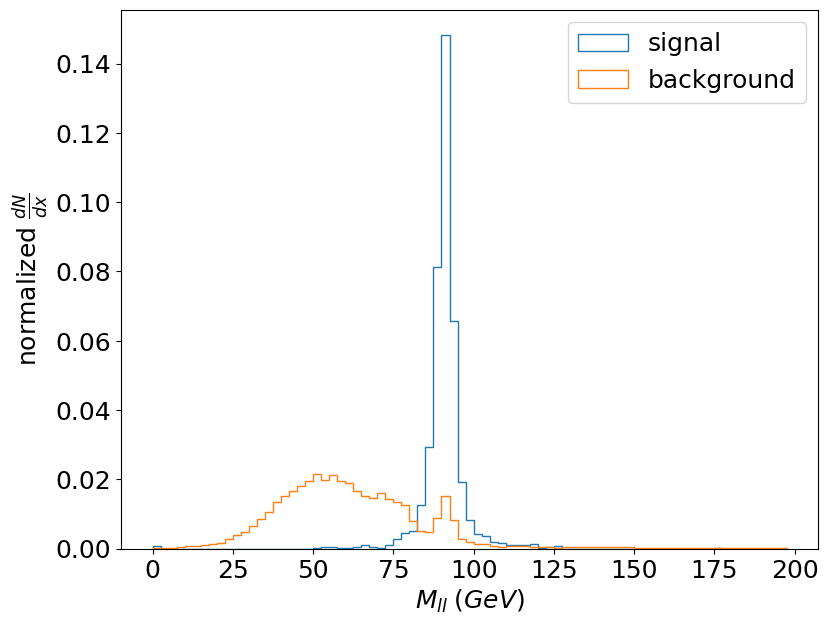

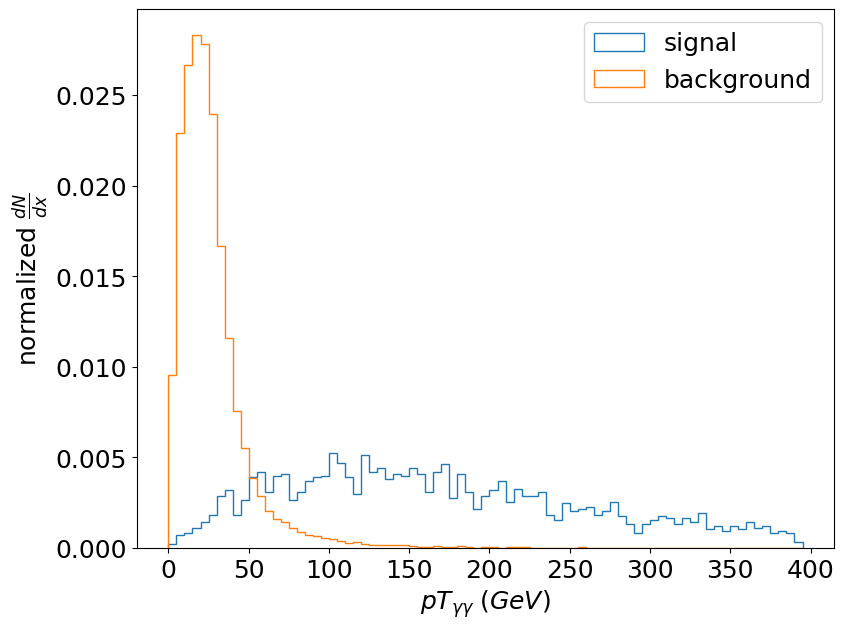

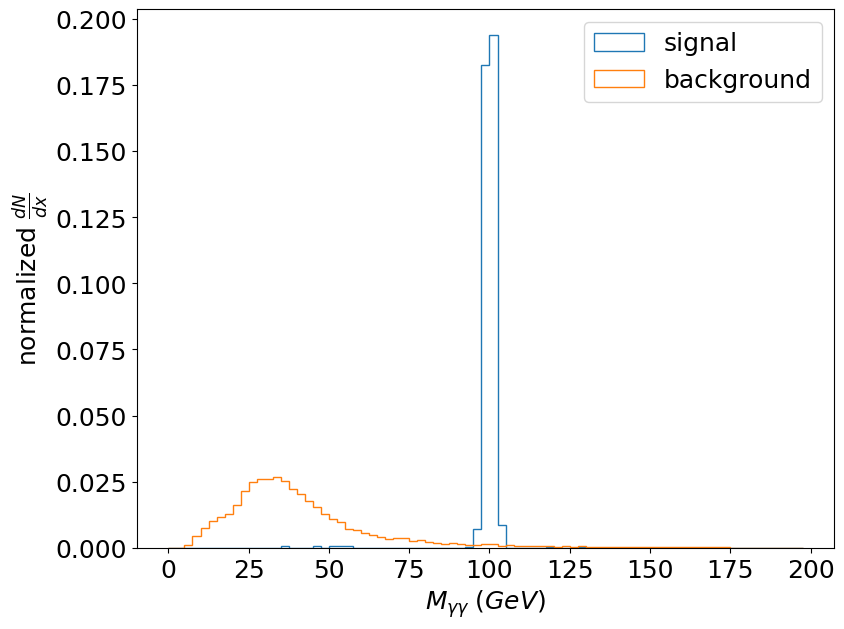

signal events: 2084
background events: 18324

selected signal events: 1926
selected background events: 2487


In [6]:
##### plot m_ll, m_aa and pT_aa #####

sig_m_ll = []
bg_m_ll = []
sig_m_aa = []
bg_m_aa = []
sig_pT_aa = []
bg_pT_aa = []

sig_electron_events, sig_electron_select = m_ll(sig_electron_events, sig_m_ll)
sig_muon_events, sig_muon_select = m_ll(sig_muon_events, sig_m_ll)

bg_electron_events, bg_electron_select = m_ll(bg_electron_events, bg_m_ll)
bg_muon_events, bg_muon_select = m_ll(bg_muon_events, bg_m_ll)

m_aa(sig_electron_events, sig_m_aa, sig_pT_aa)
m_aa(sig_muon_events, sig_m_aa, sig_pT_aa)

m_aa(bg_electron_events, bg_m_aa, bg_pT_aa)
m_aa(bg_muon_events, bg_m_aa, bg_pT_aa)

plt.figure(1, figsize=(9,7))
bins = np.arange(0,200,2.5)
plt.hist(sig_m_ll, bins=bins, label="signal", histtype='step', density=True)
plt.hist(bg_m_ll, bins=bins, label="background", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$M_{ll}\;(GeV)$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
#plt.text(170,320,"1745 signal events")
#plt.text(170,300,"1707 background events")
plt.legend(loc='best', fontsize=18)
plt.show()

plt.figure(1, figsize=(9,7))
bins = np.arange(0,400,5)
plt.hist(sig_pT_aa, bins=bins, label="signal", histtype='step', density=True)
plt.hist(bg_pT_aa, bins=bins, label="background", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$pT_{\gamma \gamma}\;(GeV)$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

plt.figure(1, figsize=(9,7))
bins = np.arange(0,200,2.5)
plt.hist(sig_m_aa, bins=bins, label="signal", histtype='step', density=True)
plt.hist(bg_m_aa, bins=bins, label="background", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$M_{\gamma \gamma}\;(GeV)$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

print("signal events:", len(sig_m_ll))
print("background events:", len(bg_m_ll))

print("\nselected signal events:", len(sig_electron_select)+len(sig_muon_select))
print("selected background events:", len(bg_electron_select)+len(bg_muon_select))

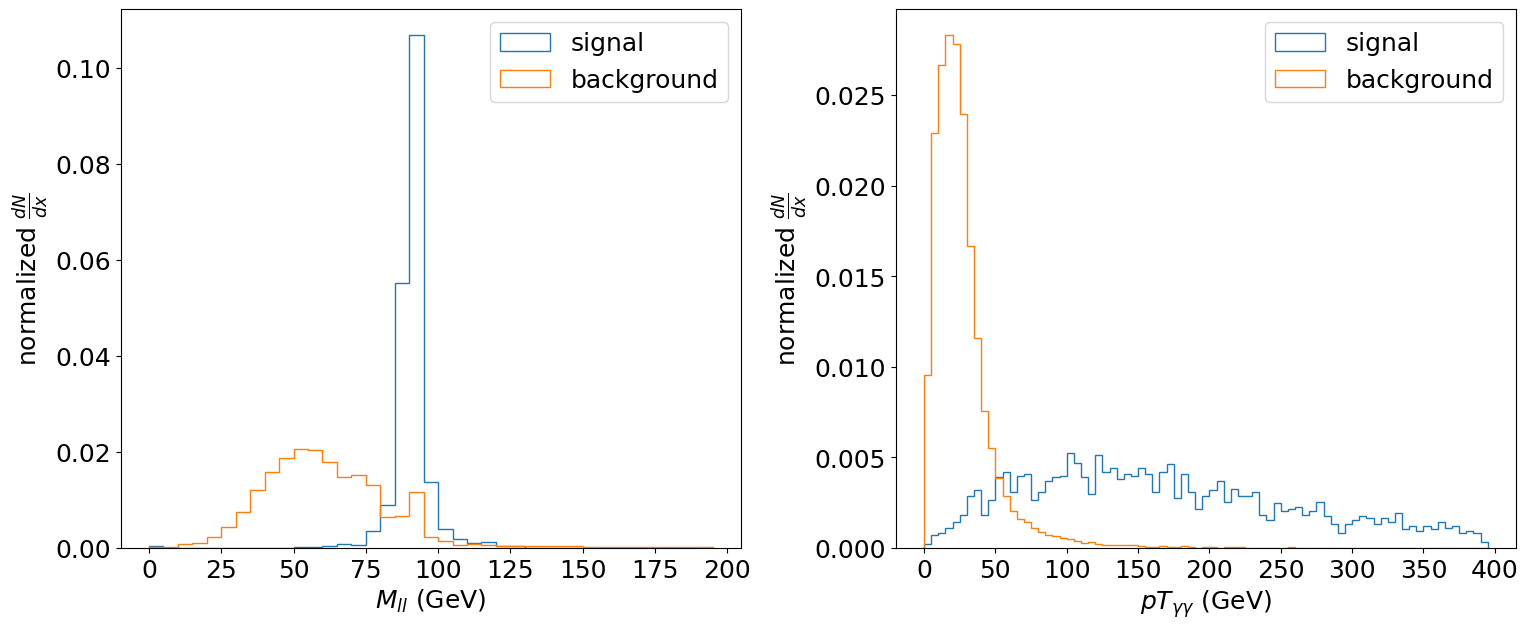

In [7]:
##### plot for paper #####

plt.figure(1, figsize=(18,7))
plt.subplots_adjust(wspace=0.25)

ax1 = plt.subplot(121)
bins = np.arange(0,200,5)
ax1.hist(sig_m_ll, bins=bins, label="signal", histtype='step', density=True)
ax1.hist(bg_m_ll, bins=bins, label="background", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$M_{ll} ~\rm{(GeV)}$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=18)

ax2 = plt.subplot(122)
bins = np.arange(0,400,5)
ax2.hist(sig_pT_aa, bins=bins, label="signal", histtype='step', density=True)
ax2.hist(bg_pT_aa, bins=bins, label="background", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$pT_{\gamma \gamma} ~\rm{(GeV)}$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=18)

plt.show()


In [8]:
##### select pT_aa #####

sig_electron_select = select_pT_aa(sig_electron_select)
sig_muon_select = select_pT_aa(sig_muon_select)

bg_electron_select = select_pT_aa(bg_electron_select)
bg_muon_select = select_pT_aa(bg_muon_select)

print("signal events after pT_aa selection:", len(sig_electron_select)+len(sig_muon_select))
print("background events after pT_aa selection:", len(bg_electron_select)+len(bg_muon_select))

##### select m_aa #####

sig_electron_select = select_m_aa(sig_electron_select)
sig_muon_select = select_m_aa(sig_muon_select)

bg_electron_select = select_m_aa(bg_electron_select)
bg_muon_select = select_m_aa(bg_muon_select)

print("\nsignal events after m_aa selection:", len(sig_electron_select)+len(sig_muon_select))
print("background events after m_aa selection:", len(bg_electron_select)+len(bg_muon_select))

signal events after pT_aa selection: 1582
background events after pT_aa selection: 304

signal events after m_aa selection: 1565
background events after m_aa selection: 43


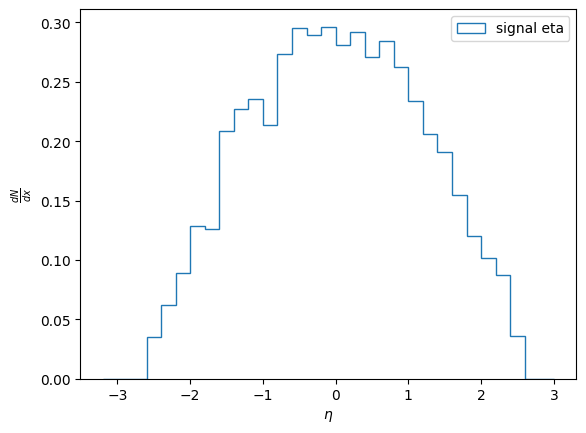

In [9]:
eta = []
bins = np.arange(-3.2,3.2,0.2)
collect_eta(sig_electron_events, eta)
collect_eta(sig_muon_events, eta)
plt.hist(eta, label='signal eta', histtype='step', bins=bins, density=True)
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\frac{dN}{dx}$")
plt.legend(loc='best')
plt.show()

In [10]:
##### event information #####

event_num = 0
print("In the", event_num, "th of events:\n")
for i in range(len(features)):
    print(features[i], ":", sig_electron_events[event_num][i])

In the 0 th of events:

Electron : 2
Electron.PT : [357.76077  47.90972]
Electron.Phi : [-2.633391  -1.7823135]
Electron.Eta : [1.3609755 1.1970093]
Muon : 0
Muon.PT : []
Muon.Phi : []
Muon.Eta : []
Photon : 2
Photon.PT : [248.78198 145.83932]
Photon.Phi : [0.45538792 0.87791127]
Photon.Eta : [-0.63752335 -0.9611045 ]


In [11]:
##### calculate significance and parameter limit in Luminosity = 300(fb^-1) #####

N_sim_sig = 10000
N_sim_bg = 100000
Nselected_sig = 1626
Nselected_bg = 43
Xsection_sig = 506.49175    ### unit:fb
Xsection_bg = 99.09201    ### unit:fb
Luminosity = 300    ### unit:fb^-1
sim_f_a = 1000    ### unit:GeV
C_Wtil = 2
C_Btil = 1
sin_W_square = 0.22290    ### sine square of Weinberg angle
cos_W_square = 1-sin_W_square    ### cosine square of Weinberg angle

print("In Luminosity = 300(fb^-1)\n")

s = Xsection_sig * (Nselected_sig/N_sim_sig) * Luminosity
b = Xsection_bg * (Nselected_bg/N_sim_bg) * Luminosity

Z = significance(s,b)
print("significance:", Z)

exp_s = Z2(b)
expected_Xsection = exp_s*(N_sim_sig/Nselected_sig)/Luminosity

f_a_limit = sim_f_a*np.sqrt(Xsection_sig/expected_Xsection)
g_azz_limit = 4*(C_Btil*sin_W_square+C_Wtil*cos_W_square)/f_a_limit
g_azgamma_limit = 8*np.sqrt(sin_W_square)*np.sqrt(cos_W_square)*(C_Wtil-C_Btil)/f_a_limit
print("\nupper limit of f_a:", f_a_limit, "(GeV)")
print("lower limit of g_azz:", g_azz_limit, "(GeV^-1)")
print("lower limit of g_azy:", g_azgamma_limit, "(GeV^-1)")

error_Z = error_significance(s,b)
print("\nsignificance with systematic uncertainty:", error_Z)
error_exp_s = error_Z2(b)
error_expected_Xsection = error_exp_s*(N_sim_sig/Nselected_sig)/Luminosity
error_f_a_limit = sim_f_a*np.sqrt(Xsection_sig/error_expected_Xsection)
error_g_azz_limit = 4*(C_Btil*sin_W_square+C_Wtil*cos_W_square)/error_f_a_limit
error_g_azgamma_limit = 8*np.sqrt(sin_W_square)*np.sqrt(cos_W_square)*(C_Wtil-C_Btil)/error_f_a_limit
print("\nupper limit of f_a with systematic uncertainty:", error_f_a_limit, "(GeV)")
print("lower limit of g_azz with systematic uncertainty:", error_g_azz_limit, "(GeV^-1)")
print("lower limit of g_azy with systematic uncertainty:", error_g_azgamma_limit, "(GeV^-1)\n")

In Luminosity = 300(fb^-1)

significance: 569.8268862707064
expectation signal events that Z=2: 7.790095332663222 
expected significance: 2.0000000000374936

upper limit of f_a: 56316.505642711876 (GeV)
lower limit of g_azz: 0.00012622232006186134 (GeV^-1)
lower limit of g_azy: 5.912181744263196e-05 (GeV^-1)

significance with systematic uncertainty: 326.1408160140657
expectation signal events with systematic uncertainty that Z=2: 8.414152004015062 
expected significance with systematic uncertainty: 2.000000000045676

upper limit of f_a with systematic uncertainty: 54187.8486542729 (GeV)
lower limit of g_azz with systematic uncertainty: 0.00013118070151396346 (GeV^-1)
lower limit of g_azy with systematic uncertainty: 6.144429513816506e-05 (GeV^-1)



In [12]:
##### calculate significance and parameter limit in Luminosity = 3000(fb^-1) #####

Luminosity = 3000    ### unit:fb^-1
print("In Luminosity = 3000(fb^-1)")

s = Xsection_sig * (Nselected_sig/N_sim_sig) * Luminosity
b = Xsection_bg * (Nselected_bg/N_sim_bg) * Luminosity
print("signal and background events:", s,b)

Z = significance(s,b)
print("significance:", Z)

exp_s = Z2(b)
expected_Xsection = exp_s*(N_sim_sig/Nselected_sig)/Luminosity

f_a_limit = sim_f_a*np.sqrt(Xsection_sig/expected_Xsection)
g_azz_limit = 4*(C_Btil*sin_W_square+C_Wtil*cos_W_square)/f_a_limit
g_azgamma_limit = 8*np.sqrt(sin_W_square)*np.sqrt(cos_W_square)*(C_Wtil-C_Btil)/f_a_limit
print("\nupper limit of f_a:", f_a_limit, "(GeV)")
print("lower limit of g_azz:", g_azz_limit, "(GeV^-1)")
print("lower limit of g_azy:", g_azgamma_limit, "(GeV^-1)")

error_Z = error_significance(s,b)
print("\nsignificance with systematic uncertainty:", error_Z)
error_exp_s = error_Z2(b)
error_expected_Xsection = error_exp_s*(N_sim_sig/Nselected_sig)/Luminosity
error_f_a_limit = sim_f_a*np.sqrt(Xsection_sig/error_expected_Xsection)
error_g_azz_limit = 4*(C_Btil*sin_W_square+C_Wtil*cos_W_square)/error_f_a_limit
error_g_azgamma_limit = 8*np.sqrt(sin_W_square)*np.sqrt(cos_W_square)*(C_Wtil-C_Btil)/error_f_a_limit
print("\nupper limit of f_a with systematic uncertainty:", error_f_a_limit, "(GeV)")
print("lower limit of g_azz with systematic uncertainty:", error_g_azz_limit, "(GeV^-1)")
print("lower limit of g_azy with systematic uncertainty:", error_g_azgamma_limit, "(GeV^-1)\n")

In Luminosity = 3000(fb^-1)
signal and background events: 247066.67565 127.8286929
significance: 1801.9508326171626
expectation signal events that Z=2: 23.269545673199723 
expected significance: 1.9999999999965379

upper limit of f_a: 103041.72817005747 (GeV)
lower limit of g_azz: 6.89856442262738e-05 (GeV^-1)
lower limit of g_azy: 3.2312483735913134e-05 (GeV^-1)

significance with systematic uncertainty: 533.0206075334469
expectation signal events with systematic uncertainty that Z=2: 36.533035529976104 
expected significance with systematic uncertainty: 1.9999999999750289

upper limit of f_a with systematic uncertainty: 82236.42195568362 (GeV)
lower limit of g_azz with systematic uncertainty: 8.643858561636649e-05 (GeV^-1)
lower limit of g_azy with systematic uncertainty: 4.048734230447936e-05 (GeV^-1)



In [13]:
t2 = time.time()
print("start time:", t1)
print("end time:", t2)
print("duration:", t2-t1)

start time: 1712557157.2042716
end time: 1712557167.033466
duration: 9.82919454574585
